# <img style="float: left; padding-right: 10px; width: 45px" src="https://raw.githubusercontent.com/Harvard-IACS/2018-CS109A/master/content/styles/iacs.png"> Data Science 2: Advanced Topics in Data Science 
## Homework 3 - Bayesian Analysis



**Harvard University**<br/>
**Spring 2020**<br/>
**Instructors**: Mark Glickman, Pavlos Protopapas, & Chris Tanner 


<hr style="height:2pt">

### Homework 3 is due March 5th

In [1]:
#PLEASE RUN THIS CELL 
import requests
from IPython.core.display import HTML
styles = requests.get("https://raw.githubusercontent.com/Harvard-IACS/2018-CS109A/master/content/styles/cs109.css").text
HTML(styles)

### INSTRUCTIONS

- To submit your assignment, please follow the instructions on Canvas.
- Please restart the kernel and run the entire notebook again before you submit.

<hr style="height:2pt">

### Please use the libraries below:

In [2]:
import pandas as pd
import numpy as np
import pymc3 as pm
import matplotlib.pyplot as plt
%matplotlib inline 
from datetime import datetime as dt
from scipy.special import expit


<hr style="height:2pt">

### Contraceptive Usage by Bangladeshi Women

In the second part of this assignment, you are provided with data sets `dataset_2_train.csv` and `dataset_2_test.csv`containing details of contraceptive usage by 1934 Bangladeshi women. There are four attributes for each woman, along with a label indicating if she uses contraceptives. The attributes include
* district: identifying code for the district the woman lives in
* urban: type of region of residence
* living.children: number of living children
* age-mean: age of the woman (in years, centered around mean)

The women are grouped into 60 districts. The task is to build a classification model that can predict if a given woman uses contraceptives.


### Part A: Bayesian Logistic Regression

The first model we will fit to the contraceptives data is a varying-intercept logistic regression model, where the intercept varies by district.

Prior distribution:

$\beta_{0j} \sim N(\mu_0,\sigma_0^2),$ with $\mu_0 \sim N(0,10000)$ and $\frac{1}{\sigma^2_0} \sim \text{Gamma}(0.1,0.1)$.

$\beta_1 \sim N(0,10000)$, $\beta_2\sim N(0,10000)$, $\beta_3 \sim N(0,10000)$

Model for data:

$Y_{ij} \sim \text{Bernoulli}(p_{ij})$

$\text{logit}\:p_{ij} = \beta_{0j} + \beta_1 \times \text{urban} + \beta_2 \times \text{living.children} + \beta_3 \times \text{age-mean}$,

where $Y_{ij}$ is 1 if woman $i$ in district $j$ uses contraceptives, and 0 otherwise, and where $i \in \{1,...,N\}$ and $j \in \{1,...,J\}$. $N$ is the number of observations in the data, and $J$ is the number of districts. The above notation assumes $N(\mu, \sigma^2)$ is a Normal distribution with mean $\mu$ and variance $\sigma^2$.

##### **A1**

As a preprocessing step, map the district number 61 to the number 54 so that the districts are in order. Also, re-name district 60 to be district 0 so that the districts are numbered 0 through 59. **We use this numbering throughout the homework, and will grade using these district numbers**

In [3]:
#read in data
train = pd.read_csv("./data/dataset_2_train.csv")
test = pd.read_csv("./data/dataset_2_test.csv")
train.head(10)
train.dtypes

district               int64
urban                  int64
living.children        int64
age_mean             float64
contraceptive_use      int64
dtype: object

In [4]:
train.describe()

,district,urban,living.children,age_mean,contraceptive_use
count,967.000000,967.000000,967.000000,967.000000,967.000000
mean,29.680455,0.307135,2.591520,-0.310626,0.389866
std,17.713976,0.461545,1.248457,8.995747,0.487972
min,1.000000,0.000000,1.000000,-13.560000,0.000000
25%,14.000000,0.000000,1.000000,-7.560000,0.000000
50%,29.000000,0.000000,3.000000,-1.559900,0.000000
75%,46.000000,1.000000,4.000000,6.440000,1.000000
max,61.000000,1.000000,4.000000,19.440000,1.000000


In [5]:
#preprocessing
train.loc[train['district'] == 61, 'district'] = 54
train.loc[train['district'] == 60, 'district'] = 0

In [6]:
train.head()
train.describe()

,district,urban,living.children,age_mean,contraceptive_use
count,967.000000,967.000000,967.000000,967.000000,967.000000
mean,28.707342,0.307135,2.591520,-0.310626,0.389866
std,17.408268,0.461545,1.248457,8.995747,0.487972
min,0.000000,0.000000,1.000000,-13.560000,0.000000
25%,14.000000,0.000000,1.000000,-7.560000,0.000000
50%,29.000000,0.000000,3.000000,-1.559900,0.000000
75%,45.000000,1.000000,4.000000,6.440000,1.000000
max,59.000000,1.000000,4.000000,19.440000,1.000000


##### **A2**

First, we'll verify that pymc3 can recover the hidden parameter values. To do so, we'll hard-code known values and simulate data from the model, then using that data we'll check if pymc3 can get back the parameters we hard-coded. If it does, we'll have hope that it can get the hidden parameter values that generated the real data.

Use the following hard-coded values:  
$\mu_0 = 2$

$\sigma^2_0 = 1$

$\beta_{0j} \sim N(\mu_0,\sigma_0^2)$ for all sixty districts

$\beta_1 = 4$

$\beta_2 = -3$

$\beta_3 = -2$

**Verify that these parameters give an overall average of 46 to 48 percent of subjects using contraceptives**

In [9]:

## Initialize random number generator
np.random.seed(123)

# Hard code parameter values 
mu, sigma = 2, 1
beta = [4,-3,-2]


# Size of dataset
size = train.district.nunique()
beta0= np.random.normal(mu, sigma, size)

# Predictor variable
X0 = train.iloc[:, 0] # district
X1 = train.iloc[:, 1] #urban
X2 = train.iloc[:, 2]  #living children
X3 = train.iloc[:, 3]   # age mean

# Simulate outcome variable
#using this formula to calculate the probability: 𝑝𝑖𝑗=e(𝛽0𝑗+𝛽1×urban+𝛽2×living.children+𝛽3×age-mean) 
P = expit(beta0[train['district']] + beta[0]*X1 + beta[1]*X2 + beta[2]*X3 )
#simulate y based on P, y follows Bernoulli(pij)
Y_i = np.random.binomial(n=1, p=P)
##add simulated Y to train data
train['Y_i'] =  Y_i


In [11]:
sim_prop = train.Y_i.mean()
print ("Simulated Proportion of women using contraceptives = \t{0:.3f}%\n".format(sim_prop*100))

train.head()

Simulated Proportion of women using contraceptives = 	47.466%



,district,urban,living.children,age_mean,contraceptive_use,Y_i
0,35,0,4,2.4400,0,0
1,22,0,2,-1.5599,1,0
2,29,0,2,-8.5599,1,1
3,5,0,3,-4.5599,1,1
4,34,1,4,8.4400,0,0


##### **A3**

Fit the varying-intercept model specified above to your simulated data. Reasonably good convergence may require adjustments to the number of tuning samples and the target acceptance rate as suggested in pymc3's warnings.

Note: It is wise to take advantage of a model's built-in `summary` method to inspect it after fitting

In [12]:
# Initialize random number generator
np.random.seed(123)

from pymc3 import Model, Normal, Binomial

basic_model = pm.Model()

with basic_model:
# define prior metrics
    ##parameters
    mu_0= pm.Normal('mu', mu=0,sd=100)
    sigma_sq = pm.InverseGamma('sigma_sq',0.1,0.1 )
    sigma = sigma_sq**0.5
    
    ##beta1-3
    beta1= pm.Normal('beta1',mu =0, sd = 100)
    beta2= pm.Normal('beta2',mu =0 , sd =100)
    beta3= pm.Normal('beta3', mu =0 , sd =100)
    
    ##beta0
  
    #def beta_0():
   #   return pm.Normal('beta_0', mu=mu_0, sd=sigma, shape = size)
   #  beta0= pm.Deterministic('beta0', beta_0())
    beta_0= pm.Normal('beta_0', mu=0, sd=1, shape=size)
    beta0= pm.Deterministic('beta0', mu_0 + beta_0*sigma)
    beta0_j = beta0[train['district'].values]
    
    
    
    ##probability
    P_i =pm.Deterministic('$P_i$',  pm.math.invlogit( beta0_j + beta1*X1 + beta2*X2 + beta3*X3 ))
    
    
    ##likelihood
    Y = train['Y_i']
    Y_obs = pm.Bernoulli('Y_obs', p=P_i, observed=Y)
    

In [13]:
with basic_model:
    # Sample from the posterior
    trace = pm.sample(draws=2000,  tune=2000, 
                      target_accept=0.9)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [beta_0, beta3, beta2, beta1, sigma_sq, mu]
Sampling 4 chains, 0 divergences: 100%|██████████| 16000/16000 [01:05<00:00, 242.76draws/s]
The number of effective samples is smaller than 25% for some parameters.


In [14]:
# display the summary
display(pm.summary(trace, var_names=['mu', 'sigma_sq', 'beta1', 'beta2', 'beta3']))

,mean,sd,hpd_3%,hpd_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
mu,2.670,1.308,0.333,5.178,0.023,0.018,3292.0,2506.0,3797.0,2933.0,1.00
sigma_sq,7.403,7.939,0.024,20.191,0.262,0.185,921.0,921.0,1019.0,1568.0,1.01
beta1,7.673,2.682,3.685,12.876,0.079,0.060,1163.0,992.0,1431.0,1527.0,1.01
beta2,-4.861,1.458,-7.622,-2.650,0.045,0.033,1051.0,986.0,1299.0,1455.0,1.01
beta3,-3.109,0.955,-4.866,-1.609,0.030,0.022,1008.0,941.0,1230.0,1481.0,1.01


##### **A4**

Plot the trace plots of the MCMC sampler for the parameters $\mu_0, \sigma_0, \beta_1, \beta_2, \beta_3$. Based on these and the R-hat values, does it look like the samplers converged?

/Users/rberi/anaconda3/envs/cs109b/lib/python3.7/site-packages/arviz/plots/backends/matplotlib/distplot.py:38: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  "Argument backend_kwargs has not effect in matplotlib.plot_dist"
/Users/rberi/anaconda3/envs/cs109b/lib/python3.7/site-packages/arviz/plots/backends/matplotlib/distplot.py:38: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  "Argument backend_kwargs has not effect in matplotlib.plot_dist"
/Users/rberi/anaconda3/envs/cs109b/lib/python3.7/site-packages/arviz/plots/backends/matplotlib/distplot.py:38: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  "Argument backend_kwargs has not effect in matplotlib.plot_dist"
/Users/rberi/anaconda3/envs/cs109b/lib/python3.7/site-packages/arviz/plots/backends/matplotlib/distplot.py:38: UserWarning: Argument backend_kwargs has no

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fb873a8cd10>,
      dtype=object)

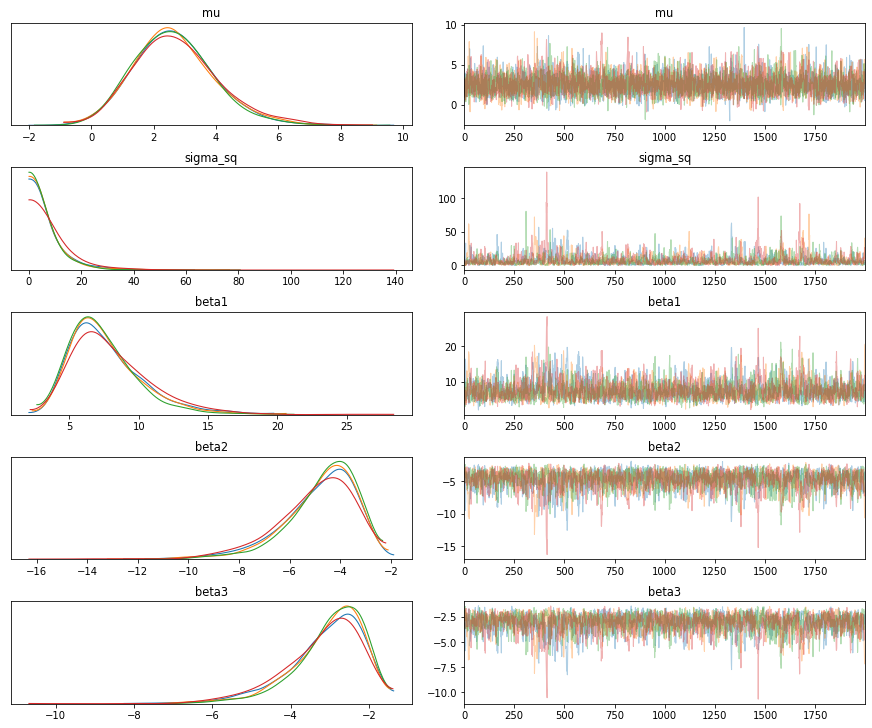

In [15]:
#your code here
from pymc3 import traceplot


pm.traceplot(trace, 
                 var_names=['mu', 'sigma_sq', 'beta1', 'beta2', 'beta3'], 
                 compact=False)

## Conclusion:
The Rhats are 1. The trace plots exhibit rapid up-and-down variation with no long-term trends or drifts, which indicate pretty good converges.
Therefore my conclusion is that the samplers did converge.

your response here

##### **A5**

Plot histograms of the posterior distributions for the parameters $\beta_{0,9}$, $\beta_{0,19}$, $\beta_{0,29}$, ..., $\beta_{0,59}$. Are the actual parameters that you generated contained within these posterior distributions? 

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7fb873e4dbd0>,
      dtype=object)

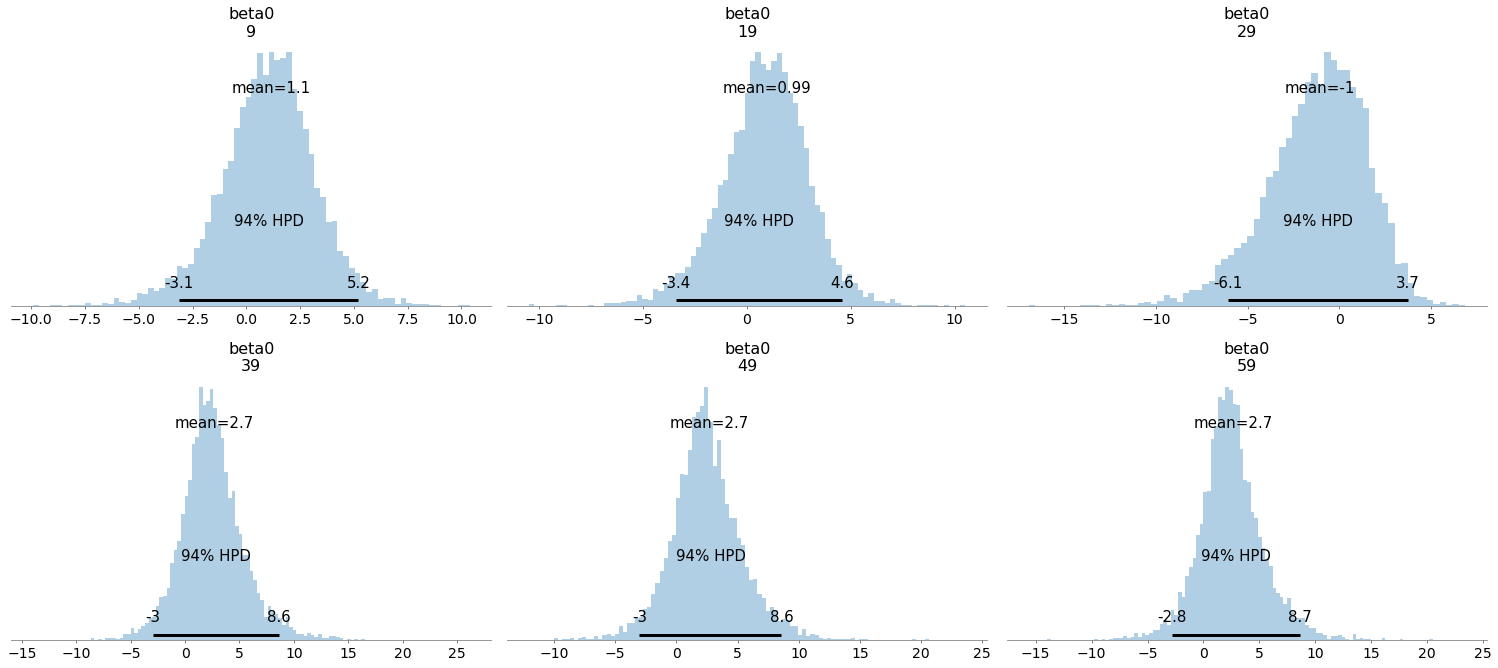

In [16]:
range= np.arange(9,69,10)
pm.plots.plot_posterior(trace, var_names = 'beta0', kind='hist', coords={'beta0_dim_0': range})

your response here


##### **A6**

We now fit our model to the actual data. Fit the varying-intercept model to the real training data.

In [17]:
#Fit to the train data
# Initialize random number generator
np.random.seed(278)

from pymc3 import Model, Normal, Binomial

basic_model2 = pm.Model()

with basic_model2:
# define prior metrics
    ##parameters
    mu_0= pm.Normal('mu', mu=0,sd=100)
    sigma_sq = pm.InverseGamma('sigma_sq',0.1,0.1 )
    sigma = sigma_sq**0.5
    
    ##beta1-3
    beta1= pm.Normal('beta1',mu =0, sd = 100)
    beta2= pm.Normal('beta2',mu =0 , sd =100)
    beta3= pm.Normal('beta3', mu =0 , sd =100)
    
    ##beta0
  
    #def beta_0():
    beta_0= pm.Normal('beta_0', mu=0, sd=1, shape=size)
    beta0= pm.Deterministic('beta0', mu_0 + beta_0*sigma)
    beta0_j = beta0[train['district'].values]
    
    
    
    ##probability
    P_i =pm.Deterministic('$P_i$',  pm.math.invlogit( beta0_j + beta1*X1 + beta2*X2 + beta3*X3 ))
    
    ##Now i fit to the original data :train['contraceptive_use']
    ##likelihood
    Y = train['contraceptive_use']
    Y_obs = pm.Bernoulli('Y_obs', p=P_i, observed=Y)
    
    with basic_model2:
    # Sample from the posterior
        trace = pm.sample(draws=2000,  tune=2000, 
                      target_accept=0.9)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [beta_0, beta3, beta2, beta1, sigma_sq, mu]
Sampling 4 chains, 0 divergences: 100%|██████████| 16000/16000 [00:25<00:00, 629.76draws/s]


##### **A7**

Check the convergence by examining the trace plots and R-hats, as you did with the simulated data. What do you observe?

In [18]:
# display the summary
display(pm.summary(trace, var_names=['mu', 'sigma_sq', 'beta1', 'beta2', 'beta3']))

,mean,sd,hpd_3%,hpd_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
mu,-1.602,0.253,-2.084,-1.139,0.004,0.003,3727.0,3678.0,3730.0,4803.0,1.0
sigma_sq,0.301,0.122,0.103,0.529,0.002,0.001,3564.0,3564.0,3409.0,5043.0,1.0
beta1,0.740,0.164,0.429,1.044,0.002,0.001,8126.0,7945.0,8127.0,6484.0,1.0
beta2,0.323,0.082,0.171,0.482,0.001,0.001,4057.0,3980.0,4060.0,5379.0,1.0
beta3,-0.035,0.012,-0.056,-0.013,0.000,0.000,4976.0,4818.0,4993.0,5922.0,1.0


/usr/local/lib/python3.7/site-packages/arviz/plots/backends/matplotlib/distplot.py:38: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  "Argument backend_kwargs has not effect in matplotlib.plot_dist"
/usr/local/lib/python3.7/site-packages/arviz/plots/backends/matplotlib/distplot.py:38: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  "Argument backend_kwargs has not effect in matplotlib.plot_dist"
/usr/local/lib/python3.7/site-packages/arviz/plots/backends/matplotlib/distplot.py:38: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  "Argument backend_kwargs has not effect in matplotlib.plot_dist"
/usr/local/lib/python3.7/site-packages/arviz/plots/backends/matplotlib/distplot.py:38: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  "Argument backend_kwargs has not 

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1306d4950>,
      dtype=object)

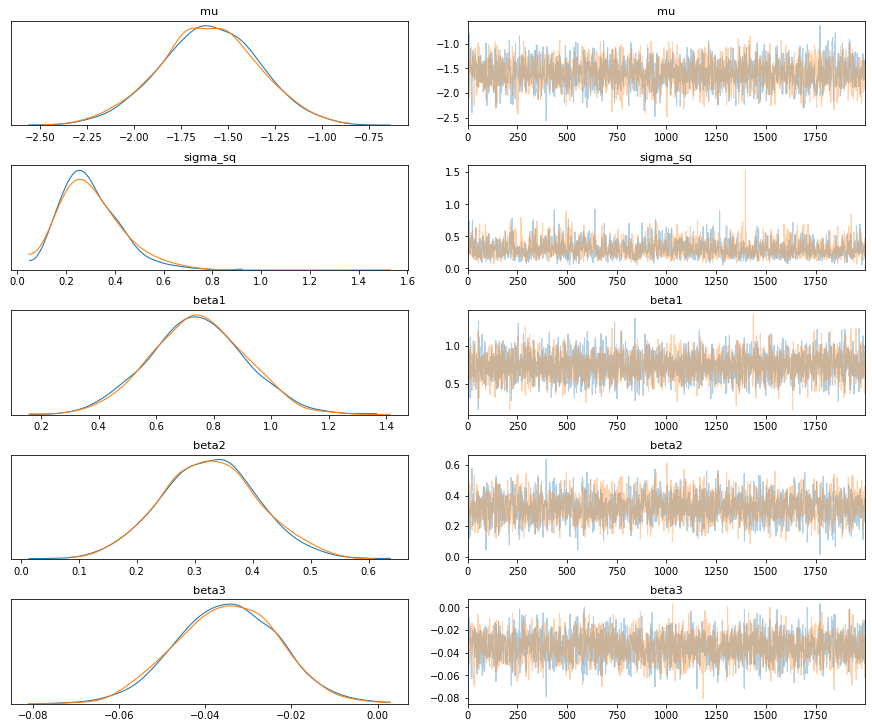

In [59]:

pm.traceplot(trace, 
                 var_names=['mu', 'sigma_sq', 'beta1', 'beta2', 'beta3'], 
                 compact=False)

This model's converge is pretty good: R hat are all 1.


##### **A8**

Based on the posterior means, which district has the highest base rate of contraceptive usage (independent of other factors like urban population)? Which district has the lowest?

In [88]:
#Visualize all beta0 value in 60 districts and the summary
(pm.summary(trace, var_names=['beta0']))

,mean,sd,hpd_3%,hpd_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
beta0[0],-2.082,0.508,-3.090,-1.172,0.008,0.006,3775.0,3560.0,3817.0,3010.0,1.0
beta0[1],-2.131,0.377,-2.799,-1.398,0.007,0.005,2862.0,2840.0,2870.0,2933.0,1.0
beta0[2],-1.774,0.492,-2.681,-0.832,0.009,0.006,3175.0,3175.0,3171.0,2913.0,1.0
beta0[3],-1.517,0.575,-2.599,-0.448,0.009,0.007,3862.0,3460.0,3886.0,2974.0,1.0
beta0[4],-1.447,0.476,-2.325,-0.549,0.007,0.005,4523.0,4067.0,4513.0,3043.0,1.0
beta0[5],-1.608,0.475,-2.530,-0.764,0.007,0.005,4124.0,3854.0,4149.0,3400.0,1.0
beta0[6],-1.971,0.409,-2.746,-1.241,0.007,0.005,3639.0,3493.0,3651.0,3000.0,1.0
beta0[7],-2.013,0.494,-3.000,-1.173,0.009,0.007,2924.0,2795.0,2971.0,2957.0,1.0
beta0[8],-1.381,0.440,-2.197,-0.559,0.007,0.005,3774.0,3378.0,3794.0,2809.0,1.0
beta0[9],-2.069,0.542,-3.083,-1.082,0.009,0.007,3282.0,3176.0,3304.0,2744.0,1.0


In [94]:
#Since the question is about the base rate, we only look at the intercept of the model
beta_list = pm.summary(trace, var_names=['beta0'])['mean']

beta0[0]    -2.082
beta0[1]    -2.131
beta0[2]    -1.774
beta0[3]    -1.517
beta0[4]    -1.447
beta0[5]    -1.608
beta0[6]    -1.971
beta0[7]    -2.013
beta0[8]    -1.381
beta0[9]    -2.069
beta0[10]   -2.115
beta0[11]   -2.211
beta0[12]   -1.666
beta0[13]   -1.512
beta0[14]   -1.305
beta0[15]   -1.751
beta0[16]   -0.976
beta0[17]   -2.063
beta0[18]   -1.799
beta0[19]   -1.353
beta0[20]   -1.375
beta0[21]   -1.786
beta0[22]   -1.672
beta0[23]   -1.663
beta0[24]   -1.961
beta0[25]   -1.820
beta0[26]   -1.593
beta0[27]   -2.105
beta0[28]   -2.157
beta0[29]   -1.774
beta0[30]   -0.984
beta0[31]   -1.177
beta0[32]   -1.674
beta0[33]   -1.531
beta0[34]   -0.882
beta0[35]   -1.331
beta0[36]   -1.536
beta0[37]   -1.486
beta0[38]   -1.779
beta0[39]   -1.295
beta0[40]   -1.598
beta0[41]   -1.542
beta0[42]   -1.470
beta0[43]   -0.965
beta0[44]   -1.548
beta0[45]   -1.979
beta0[46]   -0.966
beta0[47]   -1.400
beta0[48]   -1.303
beta0[49]   -1.764
beta0[50]   -1.593
beta0[51]   -1.338
beta0[52]   

In [82]:
# Get the maximum intercept
maxElement = np.amax(beta_list)
print('Max intercept is : ', maxElement)

# Get the district with max intercept
MaxDistrict= np.where(beta_list == maxElement)
print('The district has max base contraceptive usage is:', MaxDistrict[0])

# Get the minimum intercept
minElement = np.amin(beta_list)
print('Min intercept is : ', minElement)

# Get the district with min intercept
MinDistrict= np.where(beta_list == minElement)
print('The district has min base contraceptive usage is:', MinDistrict[0])

Max intercept is :  -0.694
The district has max base contraceptive usage is: [56]
Min intercept is :  -2.211
The district has min base contraceptive usage is: [11]


District 11 has the lowest intercept among all. Excluding all other influencing factors, women in this district generally has lowest base rate of contraceptive usage. vice versa, women in district 56 have highest base rate. 

##### **A9**

What are the posterior means of $\mu_0$ and $\sigma^2_0$? Do these values offer any evidence in support of or against the varying-intercept model, compared to a model with a single intercept value for all districts or a model with an intercept of 0 for all districts?

In [109]:
#
mu_mean = pm.summary(trace, var_names=['mu'])['mean']
print('Posterior mean of mu_0 is ',mu_mean)

sigmasq_mean = pm.summary(trace, var_names=['sigma_sq'])['mean']

print('Postirior mean of sigmasq is ',sigmasq_mean)

Posterior mean of mu_0 is  mu   -1.607
Name: mean, dtype: float64
Postirior mean of sigmasq is  sigma_sq    0.302
Name: mean, dtype: float64


Originally the parameter mu is set to be a normal distribution with mean of 0 and sd 100. The posteria indicates a negative mu but very small sd. Based on the small sd in posteria, we conclude that varing intercept value may not be necessary. 

### Part B: Varying-Coefficients Model

The next model we will fit to the contraceptives data is a varying-coefficients logistic regression model, where the coefficients on living.children, age-mean, and urban vary by district.

$\beta_{0j} \sim N(\mu_0,\sigma_0^2),$ with $\mu_0 \sim N(0,10000)$ and $\frac{1}{\sigma_0^2} \sim \text{Gamma}(0.1,0.1)$.

$\beta_{1j} \sim N(0,\sigma_1^2)$, with $\frac{1}{\sigma^2_1} \sim \text{Gamma}(0.1,0.1)$

$\beta_{2j}\sim N(0,\sigma_2^2)$, with $\frac{1}{\sigma^2_2}\sim \text{Gamma}(0.1,0.1)$

$\beta_{3j} \sim N(0,\sigma_3^2)$, with $\frac{1}{\sigma^2_3} \sim \text{Gamma}(0.1,0.1)$

Model for data:

$Y_{ij} \sim \text{Bernoulli}(p_{ij})$

$\text{logit}\:p_{ij} = \beta_{0j} + \beta_{1j} \times \text{urban} + \beta_{2j} \times \text{living.children} + \beta_{3j} \times \text{age-mean}$,

##### **B1**

Fit the model to the real data. Plot posterior means for each of the coefficients to the predictors. What do you conclude from these graphs?

In [127]:
#fit model to variable coefficience
# Initialize random number generator
np.random.seed(278)

from pymc3 import Model, Normal, Binomial

basic_model3 = pm.Model()

with basic_model3:
# define prior metrics
    ##mu and sigma
    mu0= pm.Normal('mu0', mu=0,sd=100)
    sigma0_sq = pm.InverseGamma('sigma0_sq',0.1,0.1 )
    sigma0 = sigma0_sq**0.5
    ##beta0
    beta_0= pm.Normal('beta_0', mu=0, sd=1, shape=size)
    beta0= pm.Deterministic('beta0', mu0 + beta_0*sigma0)
    beta0_j = beta0[train['district'].values]
    
    ##beta1-3
    sigma1_sq = pm.InverseGamma('sigma1_sq',0.1,0.1 )
    sigma1 = sigma1_sq**0.5
    beta_1= pm.Normal('beta_1', mu=0, sd=1, shape=size)
    beta1= pm.Deterministic('beta1', beta_1*sigma1)
    beta1_j = beta1[train['district'].values]
    
    sigma2_sq = pm.InverseGamma('sigma2_sq',0.1,0.1 )
    sigma2 = sigma2_sq**0.5
    beta_2= pm.Normal('beta_2', mu=0, sd=1, shape=size)
    beta2= pm.Deterministic('beta2', beta_2*sigma2)
    beta2_j = beta2[train['district'].values]   
    
    sigma3_sq = pm.InverseGamma('sigma3_sq',0.1,0.1 )
    sigma3 = sigma3_sq**0.5
    beta_3= pm.Normal('beta_3', mu=0, sd=1, shape=size)
    beta3= pm.Deterministic('beta3', beta_3*sigma3)
    beta3_j = beta3[train['district'].values]    

    
    ##probability
    P_i =pm.Deterministic('$P_i$',  pm.math.invlogit( beta0_j + beta1_j*X1 + beta2_j*X2 + beta3_j*X3 ))
    
    ##Now i fit to the original data :train['contraceptive_use']
    ##likelihood
    Y = train['contraceptive_use']
    Y_obs = pm.Bernoulli('Y_obs', p=P_i, observed=Y)
    
    with basic_model3:
    # Sample from the posterior
        trace = pm.sample(2000, tune=3000, target_accept=0.95, max_treedepth=100, cores=1, chains=4)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (4 chains in 1 job)
NUTS: [beta_3, sigma3_sq, beta_2, sigma2_sq, beta_1, sigma1_sq, beta_0, sigma0_sq, mu0]
Sampling chain 3, 0 divergences: 100%|██████████| 5000/5000 [00:55<00:00, 90.79it/s]


/usr/local/lib/python3.7/site-packages/arviz/plots/backends/matplotlib/distplot.py:38: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  "Argument backend_kwargs has not effect in matplotlib.plot_dist"
/usr/local/lib/python3.7/site-packages/arviz/plots/backends/matplotlib/distplot.py:38: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  "Argument backend_kwargs has not effect in matplotlib.plot_dist"
/usr/local/lib/python3.7/site-packages/arviz/plots/backends/matplotlib/distplot.py:38: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  "Argument backend_kwargs has not effect in matplotlib.plot_dist"
/usr/local/lib/python3.7/site-packages/arviz/plots/backends/matplotlib/distplot.py:38: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  "Argument backend_kwargs has not 

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1225990d0>,
      dtype=object)

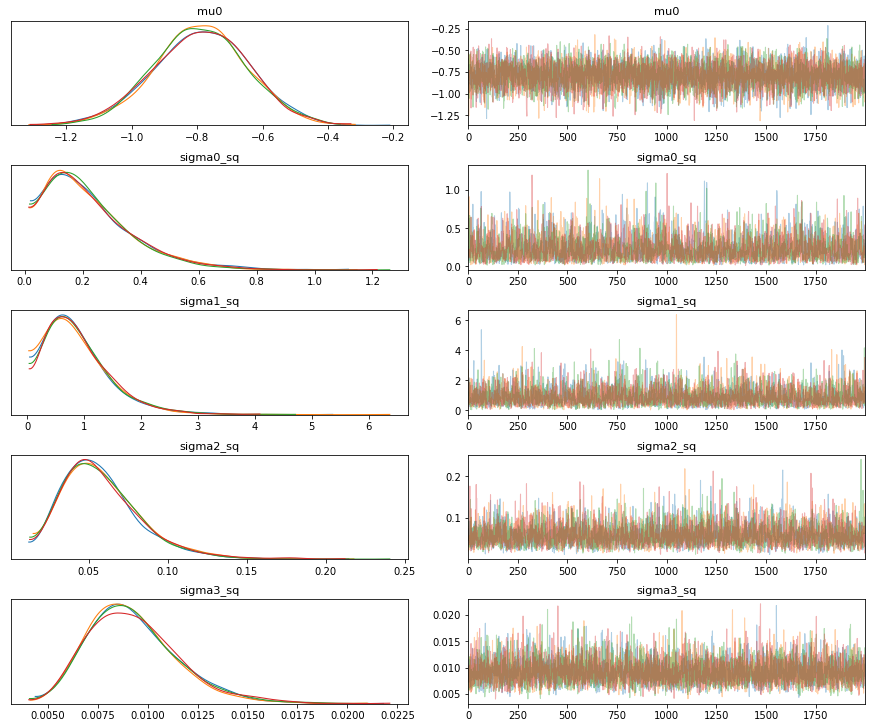

In [132]:

pm.traceplot(trace, 
                 var_names=['beta0', 'sigma0_sq','sigma1_sq', 'sigma2_sq', 'sigma3_sq'], 
                 compact=False)

In [153]:
#Summarize the parameter mean and sd
par_mean = pm.summary(trace, var_names=['mu0', 'sigma0_sq','sigma1_sq', 'sigma2_sq', 'sigma3_sq'])['mean']
par_sd= pm.summary(trace, var_names=['mu0', 'sigma0_sq','sigma1_sq', 'sigma2_sq', 'sigma3_sq'])['sd']
pd.concat([par_mean, par_sd], axis=1)

,mean,sd
mu0,-0.792,0.143
sigma0_sq,0.227,0.152
sigma1_sq,0.891,0.572
sigma2_sq,0.058,0.025
sigma3_sq,0.009,0.002


In [154]:
#Visualize the coefficient mean and sd
coeff_mean = pm.summary(trace, var_names=['beta0', 'beta1','beta2', 'beta3'])['mean']
coeff_sd = pm.summary(trace, var_names=['beta0', 'beta1','beta2', 'beta3'])['sd']
coeff_sd = pm.summary(trace, var_names=['beta0', 'beta1','beta2', 'beta3'])['sd']
pd.concat([coeff_mean, coeff_sd], axis=1)

,mean,sd
beta0[0],-1.041,0.462
beta0[1],-0.951,0.403
beta0[2],-0.872,0.435
beta0[3],-0.685,0.489
beta0[4],-0.680,0.435
...,...,...
beta3[55],-0.047,0.093
beta3[56],-0.020,0.047
beta3[57],0.041,0.063
beta3[58],0.031,0.047


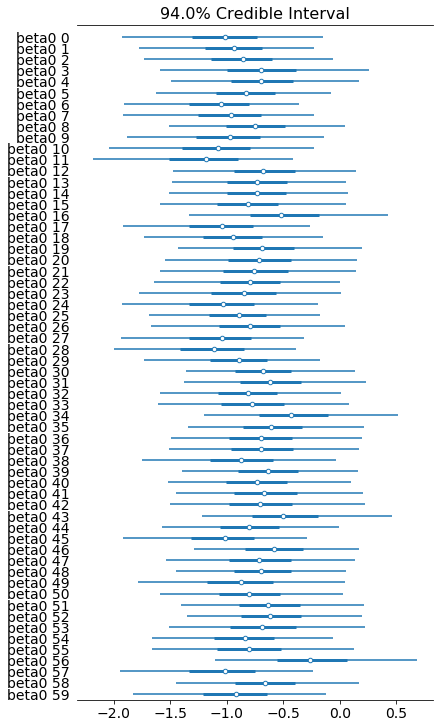

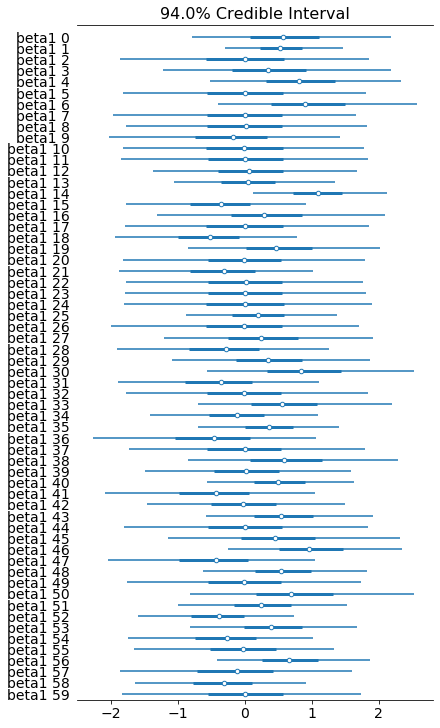

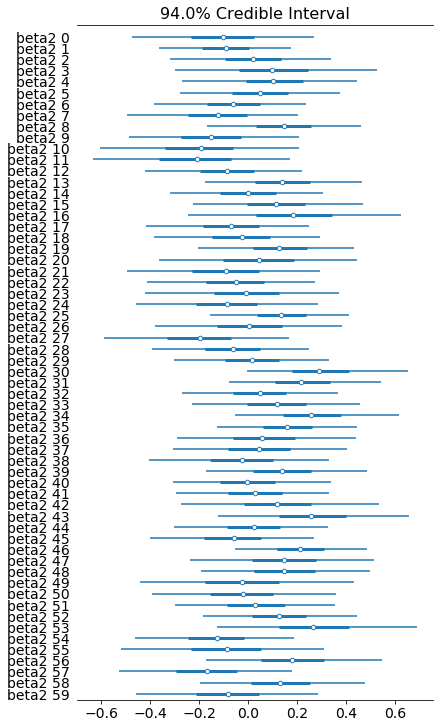

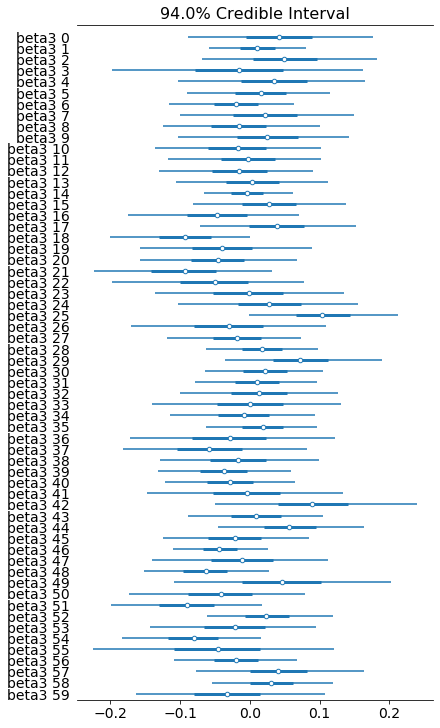

In [155]:
##Plot the mean and credible interval for the posterie model coefficience
for x in ['beta0', 'beta1','beta2', 'beta3']:
    pm.plot_forest(trace, var_names=[x], combined=True)

Overall comment:
Most coefficients' credible intervals crosses the null effect( VALUE of 0) which illustrate NO statistically significant impact of these factors. However, some coefficient do seems to be significantly impact the contraceptives usage rate. 

Urban: Some coefficience rate do not cross 0 (e.g. district 14), indicating significant impact of Urban on the contraceptives use rate. 
The coefficient values have Small variance across different district. 

Living Childrencnt: Some coefficience rate do not cross 0, indicating significant impact of Children count on the contraceptives use rate. 
Modest various across 60 districts. Make sense to have different coefficience set up for each district. 

Age: Some coefficience rate do not cross 0, indicating significant impact of Age on the contraceptives use rate.
Age factor seems to have more various impact on all 60 districts on the women's contraceptives use rate.Some district (e.g. district 42, 25) have higher impact on the usage rate, some are lower impact (e.g. district 18). Make sense to have different coefficience set up for each district. 



##### **B2**

Use all of the information you've gleaned thus far to build a final Bayesian logistic regression classifier on the train set. Then, use your model to make predictions on the test set. Report your model's classification percentage.

In [196]:
#fit model to variable coefficience
# Initialize random number generator
np.random.seed(278)

from pymc3 import Model, Normal, Binomial

basic_model4 = pm.Model()

with basic_model4:
# define prior metrics

    #intecept 
    beta0 = pm.Normal('beta0', mu=0, sd=100)
    # Beta 1 can be defined using same prior distribution (same mean and sd for all 60 district). 
    
    beta1= pm.Normal('beta1',mu =0, sd = 100)
    
    ## Beta2-3  can be defined using designated value for each district.
        
    sigma2_sq = pm.InverseGamma('sigma2_sq',0.1,0.1 )
    sigma2 = sigma2_sq**0.5
    beta_2= pm.Normal('beta_2', mu=0, sd=1, shape=size)
    beta2= pm.Deterministic('beta2', beta_2*sigma2)
    beta2_j = beta2[train['district'].values]   
    
    sigma3_sq = pm.InverseGamma('sigma3_sq',0.1,0.1 )
    sigma3 = sigma3_sq**0.5
    beta_3= pm.Normal('beta_3', mu=0, sd=1, shape=size)
    beta3= pm.Deterministic('beta3', beta_3*sigma3)
    beta3_j = beta3[train['district'].values]    

    
    ##probability
    P_i =pm.Deterministic('$P_i$',  pm.math.invlogit(  beta1*X1 + beta2_j*X2 + beta3_j*X3 ))
    
    ##Now i fit to the original data :train['contraceptive_use']
    ##likelihood
    Y = train['contraceptive_use']
    Y_obs = pm.Bernoulli('Y_obs', p=P_i, observed=Y)
    
    with basic_model4:
    # Sample from the posterior
        trace4 = pm.sample(2000, tune=3000, target_accept=0.95, max_treedepth=100, cores=1, chains=4)


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (4 chains in 1 job)
NUTS: [beta_3, sigma3_sq, beta_2, sigma2_sq, beta1, beta0]
Sampling chain 3, 0 divergences: 100%|██████████| 5000/5000 [00:25<00:00, 197.95it/s]


your response here

In [206]:
##Use the point estimates for the betas to compute the logit of p_ij for every entry in the test data-set
logpij= beta1*X1 + beta2_j*X2 + beta3_j*X3

###Use scipy expit to convert that logit p_ij to p_ij
Pij = expit(logpij )
#simulate y based on P, y follows Bernoulli(pij)
Y_obs = pm.Bernoulli('Y_obs', p=P_i, observed=Y)
###If p_ij > [cut-off], consider the prediction to be 1. Otherwise, consider the prediction to be 0
p_cutoff= 0.5

In [169]:
print(beta[1:0])

[]


In [ ]:

train['p'] = expit(train[['urban', 'living.children', 'age_mean']] @ beta[1:,0] + beta[0,0])
test['p'] = expit(test[['urban', 'living.children', 'age_mean']] @ beta[1:,0] + beta[0,0])


train['yhat'] = (train['p'] > p_cutoff)*1
test['yhat'] = (test['p'] > p_cutoff)*1


print("Training Accuracy = {}\n".format(np.sum(train['yhat'] == train['contraceptive_use'])/train['yhat'].count()))
print("Testing Accuracy = {}\n".format(np.sum(test['yhat'] == test['contraceptive_use'])/test['yhat'].count()))
